# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from huggingface_hub import login, whoami

login()

In [3]:
# DATASET CONFIG
DATASET='tyqiangz/multilingual-sentiments'
MODEL='lxyuan/distilbert-base-multilingual-cased-sentiments-student'
MIN_TOKENS=50
MAX_TOKENS=512
SAMPLES=10_000
MAX_VUS = 1024


TEXT_COLUMN='text'
DATASET_PATH='data/classification-dataset.json'
K6_BIN = "/usr/bin/k6"

HUB_DATASET_PATH = f'{whoami()["name"]}/classification-ie-optimization'

# Data

## Dataset Creation

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer
from src.process_dataset import tokenize_and_filter, sample_dataset, save_dataset

dataset = load_dataset(DATASET, 'all', split='train')

# Map numbers to text labels
label_mapping = {0: 'positive', 1: 'neutral', 2: 'negative'}
dataset = dataset.map(lambda example: {'label_text': label_mapping[example['label']]})

tokenizer = AutoTokenizer.from_pretrained(MODEL)

dataset = tokenize_and_filter(dataset, tokenizer, min_tokens=MIN_TOKENS, max_tokens=MAX_TOKENS, text_column=TEXT_COLUMN, num_proc=8)
dataset = sample_dataset(dataset, n_samples=SAMPLES ,seed=42)
save_dataset(dataset.select_columns([TEXT_COLUMN, 'label_text']), DATASET_PATH)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
2025-01-31 08:19:50.344 | SUCCESS  | src.process_dataset:sample_dataset:39 - Sampled dataset down to 10000 samples
2025-01-31 08:19:50.494 | INFO     | src.process_dataset:save_dataset:61 - Saved dataset to data/classification-dataset.json in JSON format


## Dataset Exploration
Here we can see what our data looks like. Its a rather small dataset, it might be interesting in the future to look at longer datasets.

Min:	50
Max:	509
Mean:	99.3866
StdDev:	59.00211238054564


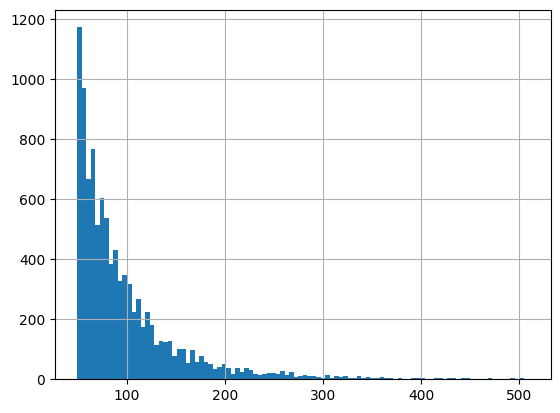

In [6]:
tokens = dataset.to_pandas().num_tokens
tokens.hist(bins=100)
print(f'Min:\t{tokens.min()}')
print(f'Max:\t{tokens.max()}')
print(f'Mean:\t{tokens.mean()}')
print(f'StdDev:\t{tokens.std()}')

# Experiments

## Experiment Structure
The config structure should be read like this:

```mermaid
graph TD;
    A["🖥️ InstanceConfig <br> Defines hardware, scaling, and GPUs"]:::instance
    A -->|Contains| B["🛳️ ImageConfig <br> Specifies Docker container and model URL"]:::image
    B -->|Contains| C["⚙️InfinityConfig <br> Configures Infinity settings like batch size"]:::infinity

    %% Define consistent styles with improved readability
    classDef instance fill:#f9c74f,stroke:#333,stroke-width:2px;
    classDef image fill:#90be6d,stroke:#333,stroke-width:2px;
    classDef infinity fill:#4A90E2,stroke:#333,stroke-width:2px;
```

In [5]:
from dataclasses import dataclass, field, asdict
from typing import Dict

@dataclass
class InstanceConfig:
    repository: str
    accelerator: str
    instance_size: str
    instance_type: str
    custom_image: Dict[str, str]  # Dict of str -> str
    vendor: str
    region: str

@dataclass
class InfinityConfig:
    INFINITY_PORT: str = "80"
    INFINITY_ENGINE: str = "torch"
    INFINITY_BATCH_SIZE: str = "16"
    INFINITY_DTYPE: str = "auto"
    INFINITY_EMBEDDING_DTYPE: str = "float32"
    INFINITY_POOLING_METHOD: str = "auto"
    INFINITY_COMPILE: str = 'true'
    INFINITY_BETTERTRANSFORMER: str = 'true'
    INFINITY_MODEL_ID: str = "/repository"

    def to_dict(self) -> Dict[str, str]:
        """Converts the dataclass to a dictionary representation."""
        return asdict(self)

@dataclass
class ImageConfig:
    health_route: str = "/health"
    url: str = "michaelf34/infinity:0.0.75-trt-onnx"
    env: InfinityConfig = field(default_factory=InfinityConfig)


In [6]:
def set_env(batch_size: int, image_config: ImageConfig) -> Dict[str, str]:
    config = asdict(image_config)
    config['env']["INFINITY_BATCH_SIZE"] = str(batch_size)
    return config

`deploy_endpoint` gives some basic features, you might want to expand this functionality for your experiments though!

In [7]:
from src.deployment import deploy_endpoint
?deploy_endpoint

Signature: deploy_endpoint(instance_config, endpoint_name, wait=False)
Docstring: Creates and deploys an inference endpoint using the given instance configuration.
File:      ~/encoder-analysis/src/deployment.py
Type:      function

## Run Experiments

In [8]:
instance_config_experiment_dicts = [
    {
        'accelerator': 'gpu',
        'instance_size': 'x1',
        'instance_type': 'nvidia-l4',
        'vendor': 'aws',
        'region': 'us-east-1',
    },
    {
        'accelerator': 'gpu',
        'instance_size': 'x1',
        'instance_type': 'nvidia-t4',
        'vendor': 'aws',
        'region': 'us-east-1',
    },
]
instance_config_experiments = [InstanceConfig(repository=MODEL, **instance_config_experiment_dict, custom_image=None) for instance_config_experiment_dict in instance_config_experiment_dicts]

In [9]:
import itertools
import copy
from pathlib import Path
from time import sleep

from loguru import logger

from src.k6 import call_k6, optimal_vus, image_dict

template_file = "classification-analysis.js.j2"
output_file = Path("./generated").resolve() / "classification-analysis.js"

start_vus = 32
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
image_urls = ['michaelf34/infinity:0.0.75-trt-onnx', 'michaelf34/infinity:0.0.75']

# Create the cross-product of batch sizes and image URLs
experiments = list(itertools.product(batch_sizes, image_urls))

for og_instance_config_experiment in instance_config_experiments:
    for image_url in image_urls:
        endpoints = []
        for batch_size in batch_sizes:
            # Configure Infinity Settings, pass them up to the image
            infinty_config = InfinityConfig(INFINITY_BATCH_SIZE=str(batch_size))
            image_config = ImageConfig(env=infinty_config, url=image_url)
    
            # Add the image to the HW instance
            instance_config_experiment = copy.deepcopy(og_instance_config_experiment)
            instance_config_experiment.custom_image = image_config
    
            # Deploy the endpoint
            logger.info(f"Running experiment with batch_size={batch_size}, image_url={image_url}")
            vendor = instance_config_experiment.vendor
            image_url_short = image_dict[image_url]
            endpoint = deploy_endpoint(instance_config_experiment, endpoint_name=f'ea-{vendor}-{image_url_short}-{batch_size}', wait=False)
            endpoints.append(endpoint)
    
        endpoints[0].wait()
        
        for endpoint in endpoints:
            endpoint.fetch()
            batch_size = endpoint.__dict__["raw"]["model"]["env"]["INFINITY_BATCH_SIZE"]
            vendor = endpoint.__dict__["raw"]["provider"]["vendor"]
            instance_type = endpoint.__dict__["raw"]["compute"]["instanceType"]
            logger.success(f'Endpoint is ready!')
            logger.info(f'\tVendor: {vendor}')
            logger.info(f'\tInstance: {instance_type}')
            logger.info(f'\tBatch Size: {batch_size}')
    
            args_dict = dict(
                text_column=TEXT_COLUMN,
                endpoint=endpoint,
                total_requests=SAMPLES,
                template_file=template_file,
                output_file=output_file,
                dataset_path=DATASET_PATH,
                k6_bin=K6_BIN
            )
    
            optimal_vus(max_vus=MAX_VUS, args_dict=args_dict, start_vus=start_vus)
            sleep(5)
            endpoint.delete()
            sleep(5)

2025-01-30 13:47:00.302 | INFO     | __main__:<module>:34 - Running experiment with batch_size=32, image_url=michaelf34/infinity:0.0.75-trt-onnx
2025-01-30 13:47:00.708 | INFO     | src.deployment:deploy_endpoint:21 - Creating inference endpoint...
2025-01-30 13:47:01.240 | INFO     | src.deployment:deploy_endpoint:40 - Waiting for endpoint to be ready...
2025-01-30 13:47:01.241 | INFO     | __main__:<module>:34 - Running experiment with batch_size=64, image_url=michaelf34/infinity:0.0.75-trt-onnx
2025-01-30 13:47:01.673 | INFO     | src.deployment:deploy_endpoint:21 - Creating inference endpoint...
2025-01-30 13:47:01.777 | INFO     | src.deployment:deploy_endpoint:40 - Waiting for endpoint to be ready...
2025-01-30 13:47:01.778 | INFO     | __main__:<module>:34 - Running experiment with batch_size=128, image_url=michaelf34/infinity:0.0.75-trt-onnx
2025-01-30 13:47:02.140 | INFO     | src.deployment:deploy_endpoint:21 - Creating inference endpoint...
2025-01-30 13:47:02.332 | INFO    

## Process Experiments

In [10]:
from src.process_dataset import load_json_files

# Define cost per hour considering both hardware type and vendor
cost_per_hour = {
    ('gcp', 'nvidia-t4'): 0.5,
    ('gcp', 'nvidia-l4'): 0.7,
    ('aws', 'nvidia-t4'): 0.5,
    ('aws', 'nvidia-l4'): 0.8,
}

# Load dataset
df = load_json_files('results/classification')

# Compute cost
df['seconds_per_billion'] = 1e9 / df['throughput_req_per_sec']
df['cost_per_sec'] = df.apply(lambda row: cost_per_hour.get((row['vendor'], row['hw_type']), 0) / 3600, axis=1)
df['1B_cost'] = df['seconds_per_billion'] * df['cost_per_sec']

df.sort_values(by='1B_cost').head()

,total_requests,test_duration_sec,successful_requests,avg_latency_ms,p95_latency_ms,accuracy_percentage,throughput_req_per_sec,hw_type,batch_size,image,engine,vendor,vus,seconds_per_billion,cost_per_sec,1B_cost
194,10000,11.422015,10000,502.9814,743.0,58.03,875.502269,nvidia-l4,64,michaelf34/infinity:0.0.75,torch,aws,448,1.142201e+06,0.000222,253.822554
106,10000,11.477969,10000,501.8690,740.0,58.01,871.234286,nvidia-l4,64,michaelf34/infinity:0.0.75-trt-onnx,torch,aws,448,1.147797e+06,0.000222,255.065974
107,10000,11.517683,10000,541.2980,779.0,58.03,868.230160,nvidia-l4,64,michaelf34/infinity:0.0.75-trt-onnx,torch,aws,480,1.151768e+06,0.000222,255.948517
108,10000,11.542635,10000,525.3836,778.0,58.01,866.353341,nvidia-l4,64,michaelf34/infinity:0.0.75-trt-onnx,torch,aws,464,1.154263e+06,0.000222,256.502990
105,10000,11.649862,10000,438.9456,641.0,58.02,858.379273,nvidia-l4,64,michaelf34/infinity:0.0.75-trt-onnx,torch,aws,384,1.164986e+06,0.000222,258.885820


In [11]:
from datasets import Dataset
# Push to the hub
dataset = Dataset.from_pandas(df)
dataset.push_to_hub(HUB_DATASET_PATH)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/862 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/derek-thomas/classification-ie-optimization/commit/a297e75d5b7ec8bf858a36ee43ee11083c2b5cbd', commit_message='Upload dataset', commit_description='', oid='a297e75d5b7ec8bf858a36ee43ee11083c2b5cbd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/derek-thomas/classification-ie-optimization', endpoint='https://huggingface.co', repo_type='dataset', repo_id='derek-thomas/classification-ie-optimization'), pr_revision=None, pr_num=None)

## CPU Experiments
This is left to the user to play with, I experimented early, but moved on since it was too expensive.

In [ ]:
instance_config_experiment_dicts = [
    {
        'accelerator': 'cpu',
        'instance_size': 'x1',
        'instance_type': 'intel-spr'
    }
]

instance_config_experiments = [InstanceConfig(repository=MODEL, **ic_exp_dict, custom_image=None) for ic_exp_dict in instance_config_experiment_dicts]

In [ ]:
from itertools import product

batch_sizes = [1, 2, 4, 8, 16, 32, 64]
infinity_engine = ['optimum', 'torch']
start_vus = 1

cross_product = list(product(batch_sizes, infinity_engine))

for og_instance_config_experiment in instance_config_experiments:
    for batch_size, infinity_engine in cross_product:
        # Configure Infinity Settings, pass them up to the image
        infinty_config = InfinityConfig(INFINITY_BATCH_SIZE=str(batch_size))
        image_config = ImageConfig(env=infinty_config)

        # Add the image to the HW instance
        instance_config_experiment = copy.deepcopy(og_instance_config_experiment)
        instance_config_experiment.custom_image = image_config

        # Deploy the endpoint
        logger.info(f'Deploying with Batch Size:\t{batch_size}')
        logger.info(f'Deploying with Infinity Engine:\t{infinity_engine}')
        endpoint = deploy_endpoint(instance_config_experiment)

        args_dict = dict(
            endpoint=endpoint,
            total_requests=10_000,
            template_file=template_file,
            output_file=output_file,
            dataset_path=DATASET_PATH,
            k6_bin=K6_BIN
        )
        
        optimal_vus(max_vus=CPU_MAX_VUS, args_dict=args_dict, start_vus=start_vus)
        endpoint.delete()
        sleep(5)